In [1]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, os
import seaborn as sns
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

seed = 42
model_save_charm = ""
DEFAULT_LOSS_PATH = "./dragonnet_default_loss"
TARREG_LOSS_PATH = "./dragonnet_tarreg_loss"
os.makedirs("./dragonnet_default_loss", exist_ok=True)
os.makedirs("./dragonnet_tarreg_loss", exist_ok=True)

# Helper functions
from helpers.helper_functions import seed_everything
seed_everything(seed)

cuda:0
--> Đã set Global Seed: 42


# 0. Prepare data

## 0.1. Split men & women dataset

In [2]:
# Data
from sklift.datasets import fetch_hillstrom
from helpers.helper_functions import print_response_stats
import pandas as pd

In [3]:
hillstrom_dataset = fetch_hillstrom()
full_data, full_target, full_treatment = fetch_hillstrom(target_col="visit",return_X_y_t=True)
pd.concat([full_data, full_target, full_treatment],axis=1).to_csv("./dataset/hillstrom_full_data_raw.csv", index=False)

mask_women = full_treatment != 'Womens E-Mail'
men_data_raw = full_data[mask_women]
men_target_raw = full_target[mask_women]
men_treatment_raw = full_treatment[mask_women]

# Xử lý biến Treatment (QUAN TRỌNG)
# Không dùng get_dummies ở đây vì dễ nhầm lẫn. Dùng map để kiểm soát 0 và 1.
# Mens E-Mail -> 1 (Treatment)
# No E-Mail   -> 0 (Control)
men_treatment_binary = men_treatment_raw.map({
    'Mens E-Mail': 1,
    'No E-Mail': 0
})
men_data = pd.get_dummies(men_data_raw, drop_first=True)
men_data_np, men_target_np, men_treatment_np = men_data.values.astype("float32"), men_target_raw.values.astype("float32"), men_treatment_binary.values.astype("float32")

# Women
mask_women = full_treatment != 'Mens E-Mail'
women_data_raw = full_data[mask_women]
women_target_raw = full_target[mask_women]
women_treatment_raw = full_treatment[mask_women]

women_treatment_binary = women_treatment_raw.map({
    'Womens E-Mail': 1,
    'No E-Mail': 0
})


women_data = pd.get_dummies(women_data_raw, drop_first=True)
women_data_np, women_target_np, women_treatment_np = women_data.values.astype("float32"), women_target_raw.values.astype("float32"), women_treatment_binary.values.astype("float32")

print("Splited data into women and men datasets")
print(f"Men: {men_data_np.shape}")
print(f"Women: {women_data_np.shape}")

Splited data into women and men datasets
Men: (42613, 15)
Women: (42693, 15)


## 0.2. Split train-set dataset & feature scaling

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split train test sets
X_men_train, X_men_test, y_men_train, y_men_test, t_men_train, t_men_test = train_test_split(
    men_data_np, men_target_np, men_treatment_np, test_size=0.2, random_state=seed, stratify=men_treatment_np
)

X_women_train, X_women_test, y_women_train, y_women_test, t_women_train, t_women_test = train_test_split(
    women_data_np, women_target_np, women_treatment_np, test_size=0.2, random_state=seed, stratify=women_treatment_np
)
print("Splited men & women datasets into train & test sets")
print(f"MEN - Train size: {X_men_train.shape[0]}, Test size: {X_men_test.shape[0]}")
print(f"WOMEN - Train size: {X_women_train.shape[0]}, Test size: {X_women_test.shape[0]}\n")

# Features scaling
scaler = StandardScaler()
X_men_train_scaled = scaler.fit_transform(X_men_train)
X_men_test_scaled = scaler.transform(X_men_test)

X_women_train_scaled = scaler.fit_transform(X_women_train)
X_women_test_scaled = scaler.transform(X_women_test)
print("Feature scaled X_men_train, X_men_test, X_women_train, X_women_test")

Splited men & women datasets into train & test sets
MEN - Train size: 34090, Test size: 8523
WOMEN - Train size: 34154, Test size: 8539

Feature scaled X_men_train, X_men_test, X_women_train, X_women_test


## 0.3. Check for response rate in the data (Positive)

In [5]:
### MEN
print("=== MEN DATASET STATS ===")
print_response_stats(y_men_train, "Men Train")
print_response_stats(y_men_test, "Men Test")

### WOMEN
print("\n=== WOMEN DATASET STATS ===")
print_response_stats(y_women_train, "Women Train")
print_response_stats(y_women_test, "Women Test")

### Overall
print("\n=== RAW HILLSTROM OVERALL ===")
print_response_stats(full_target, "Full Dataset")

=== MEN DATASET STATS ===
--- Men Train ---
Total Samples: 34090
Positive (Visits): 4899
Response Rate: 14.37% (Tỷ lệ 1:7.0)
------------------------------
--- Men Test ---
Total Samples: 8523
Positive (Visits): 1257
Response Rate: 14.75% (Tỷ lệ 1:6.8)
------------------------------

=== WOMEN DATASET STATS ===
--- Women Train ---
Total Samples: 34154
Positive (Visits): 4412
Response Rate: 12.92% (Tỷ lệ 1:7.7)
------------------------------
--- Women Test ---
Total Samples: 8539
Positive (Visits): 1088
Response Rate: 12.74% (Tỷ lệ 1:7.8)
------------------------------

=== RAW HILLSTROM OVERALL ===
--- Full Dataset ---
Total Samples: 64000
Positive (Visits): 9394
Response Rate: 14.68% (Tỷ lệ 1:6.8)
------------------------------


# 1. End to end pipeline

In [6]:
from model.end_to_end_pipeline import Dragonnet

# 2. Use

## 2.1. Default loss

In [ ]:
# dragonnet_model_men = Dragonnet(
#     input_dim=X_men_train_scaled.shape[1],
#     shared_hidden=men_data_np.shape[1],
#     device=device,
#     seed=seed
# )
# dragonnet_model_women = Dragonnet(
#     input_dim=X_women_train_scaled.shape[1],
#     shared_hidden=women_data_np.shape[1],
#     device=device,
#     seed=seed
# )

# dragonnet_model_men.fit(X_men_train_scaled, y_men_train, t_men_train, valid_perc=0.2)
# dragonnet_model_women.fit(X_women_train_scaled, y_women_train, t_women_train, valid_perc=0.2)

### Default Loss Scoring

In [ ]:
from sklift.metrics import uplift_auc_score, qini_auc_score, mean_squared_error

In [ ]:
y0_pred_men, y1_pred_men, t_pred_men, eps_men = dragonnet_model_men.predict(X_men_test_scaled)
y0_pred_women, y1_pred_women, t_pred_women, eps_women = dragonnet_model_women.predict(X_women_test_scaled)

y_pred_final_men = t_men_test.flatten().reshape(-1, 1) * y1_pred_men + (1 - t_men_test.flatten().reshape(-1, 1)) * y0_pred_men
y_pred_final_women = t_women_test.flatten().reshape(-1, 1) * y1_pred_women + (1 - t_women_test.flatten().reshape(-1, 1)) * y0_pred_women


print(f"MSE Score Men (Outcome Prediction Error): {mean_squared_error(y_men_test, y_pred_final_men):.5f}")
print(f"MSE Score Women (Outcome Prediction Error): {mean_squared_error(y_women_test, y_pred_final_women):.5f}")

# Uplift scores
uplift_scores_men = (y1_pred_men - y0_pred_men).flatten()
uplift_scores_women = (y1_pred_women - y0_pred_women).flatten()

# AUUC
auuc_men = uplift_auc_score(y_men_test.flatten(),uplift_scores_men,t_men_test.flatten())
auuc_women = uplift_auc_score(y_women_test.flatten(),uplift_scores_women,t_women_test.flatten())


print(f"AUUC Score Men: {auuc_men:.4f}")
print(f"AUUC Score Women: {auuc_women:.4f}")

MSE Score Men (Outcome Prediction Error): 0.12094
MSE Score Women (Outcome Prediction Error): 0.10937
AUUC Score Men: 314.8828
AUUC Score Women: 162.1827
AUQC Score Men: 157.0306
AUQC Score Women: 80.5799
Normalized AUUC Score Men: -0.0491
Normalized AUUC Score Women: -0.0169
Normalized AUQC Score Men: -0.0378
Normalized AUQC Score Women: -0.0158
--------------------------------------------------------------
Uplift AUC Score Men: -0.0118
Uplift AUC Score Women: -0.0034
Qini AUC Score Men: -0.0232
Qini AUC Score Women: -0.0088


c:\Users\ducha\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ducha\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ducha\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureW

## 2.2. Tarreg Loss

In [8]:
best_params_men = {
    'hidden_ratio': 1.4393574109266403, 
    'outcome_ratio': 1.4774984565533944, 
    'alpha': 1.2437024665610803, 
    'beta': 1.2344106549804128, 
    'learning_rate': 0.00010404392848939661, 
    'batch_size': 64
}
best_params_women = {
    'hidden_ratio': 1.5679455286745405, 
    'outcome_ratio': 1.6483456869142235, 
    'alpha': 0.953854620029144, 
    'beta': 1.3739164009436546, 
    'learning_rate': 0.0005996383425775317, 
    'batch_size': 64
}
dragonnet_model_men_tarreg = Dragonnet(
    input_dim=X_men_train_scaled.shape[1],
    shared_hidden= int(X_men_train_scaled.shape[1] * best_params_men['hidden_ratio']),
    outcome_hidden=int(X_men_train_scaled.shape[1] * best_params_men['outcome_ratio']),
    alpha=best_params_men['alpha'],
    beta=best_params_men['beta'],
    learning_rate=best_params_men['learning_rate'],
    batch_size=best_params_men['batch_size'],
    device=device,
    loss_type="tarreg"
)
dragonnet_model_women_tarreg = Dragonnet(
    input_dim=X_women_train_scaled.shape[1],
    shared_hidden= int(X_women_train_scaled.shape[1] * best_params_women['hidden_ratio']),
    outcome_hidden=int(X_women_train_scaled.shape[1] * best_params_women['outcome_ratio']),
    alpha=best_params_women['alpha'],
    beta=best_params_women['beta'],
    learning_rate=best_params_women['learning_rate'],
    batch_size=best_params_women['batch_size'],
    device=device,
    loss_type="tarreg"
)
dragonnet_model_men_tarreg.fit(X_men_train_scaled, y_men_train, t_men_train, valid_perc=0.2)
dragonnet_model_women_tarreg.fit(X_women_train_scaled, y_women_train, t_women_train, valid_perc=0.2)

epoch: 0--------- train_loss: 575.0750 ----- valid_loss: 370.0522766113281
epoch: 1--------- train_loss: 353.1953 ----- valid_loss: 338.64013671875
epoch: 2--------- train_loss: 325.5510 ----- valid_loss: 310.7181701660156
epoch: 3--------- train_loss: 297.2286 ----- valid_loss: 282.3664855957031
epoch: 4--------- train_loss: 269.0336 ----- valid_loss: 254.6001434326172
epoch: 5--------- train_loss: 241.7512 ----- valid_loss: 228.0
epoch: 6--------- train_loss: 215.8136 ----- valid_loss: 202.8768768310547
epoch: 7--------- train_loss: 191.4495 ----- valid_loss: 179.39378356933594
epoch: 8--------- train_loss: 168.7753 ----- valid_loss: 157.62875366210938
epoch: 9--------- train_loss: 147.8417 ----- valid_loss: 137.6112518310547
epoch: 10--------- train_loss: 128.6628 ----- valid_loss: 119.34223175048828
epoch: 11--------- train_loss: 111.2294 ----- valid_loss: 102.80451202392578
epoch: 12--------- train_loss: 95.5172 ----- valid_loss: 87.96825408935547
epoch: 13--------- train_loss: 81

### Tarreg Loss Scoring

In [ ]:
y0_pred_men_tarreg, y1_pred_men_tarreg, t_pred_men_tarreg, eps_men_tarreg = dragonnet_model_men_tarreg.predict(X_men_test_scaled)
y0_pred_women_tarreg, y1_pred_women_tarreg, t_pred_women_tarreg, eps_women_tarreg = dragonnet_model_women_tarreg.predict(X_women_test_scaled)

y_pred_final_men_tarreg = t_men_test.flatten() * y1_pred_men_tarreg.flatten() + (1 - t_men_test.flatten()) * y0_pred_men_tarreg.flatten()
y_pred_final_women_tarreg = t_women_test.flatten() * y1_pred_women_tarreg.flatten() + (1 - t_women_test.flatten()) * y0_pred_women_tarreg.flatten()

mse_score_men_tarreg = mean_squared_error(y_men_test, y_pred_final_men_tarreg)
mse_score_women_tarreg = mean_squared_error(y_women_test, y_pred_final_women_tarreg)
print(f"MSE Score Men (Outcome Prediction Error): {mse_score_men_tarreg:.5f}")
print(f"MSE Score Women (Outcome Prediction Error): {mse_score_women_tarreg:.5f}")

# Uplift scores
uplift_scores_men_tarreg = (y1_pred_men_tarreg - y0_pred_men_tarreg).flatten()
uplift_scores_women_tarreg = (y1_pred_women_tarreg - y0_pred_women_tarreg).flatten()

# AUUC
auuc_men_tarreg = uplift_auc_score(y_men_test.flatten(),uplift_scores_men_tarreg,t_men_test.flatten())
auuc_women_tarreg = uplift_auc_score(y_women_test.flatten(),uplift_scores_women_tarreg,t_women_test.flatten())

print(f"AUUC Score Men Tarreg: {auuc_men_tarreg:.4f}")
print(f"AUUC Score Women Tarreg: {auuc_women_tarreg:.4f}")

# TPE

In [14]:
def objective(trial, X, y, t, device):
    # --- 1. Define Search Space theo Table 7 của Paper  ---
    
    # Hidden size & Outcome size là hệ số nhân (multiplier) trên input_dim [cite: 843-844]
    hidden_ratio = trial.suggest_float("hidden_ratio", 0.5, 2.0)
    outcome_ratio = trial.suggest_float("outcome_ratio", 0.5, 2.0)
    
    # Alpha & Beta cho Loss function
    alpha = trial.suggest_float("alpha", 0.5, 1.5)
    beta = trial.suggest_float("beta", 0.5, 1.5)
    
    # Learning rate (log scale)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-3, log=True)
    
    # Batch size (Paper không ghi cụ thể range cho batch_size trong bảng, 
    # nhưng implied qua steps_per_epoch. Ta tune batch_size để ổn định)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    
    # Tính toán kích thước layer thực tế
    input_dim = X.shape[1]
    shared_hidden = int(input_dim * hidden_ratio)
    outcome_hidden = int(input_dim * outcome_ratio) # Paper dùng multiplier cho outcome layer [cite: 740, 844]

    # --- 2. Split Validation Data cho việc Tuning ---
    # Paper dùng nested CV, ở đây ta dùng 1 tập valid đơn giản để demo nhanh
    X_train, X_val, y_train, y_val, t_train, t_val = train_test_split(
        X, y, t, test_size=0.2, random_state=42, stratify=t
    )
    
    # --- 3. Khởi tạo Model ---
    model = Dragonnet(
        input_dim=input_dim,
        shared_hidden=shared_hidden,
        outcome_hidden=outcome_hidden,
        alpha=alpha,
        beta=beta,
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=30, # Paper giới hạn 30 epochs cho DragonNet [cite: 837]
        device=device,
        loss_type='tarreg' 
    )
    
    # --- 4. Train Model ---
    # Tắt in log training để đỡ rối màn hình khi search
    try:
        model.fit(X_train, y_train, t_train, valid_perc=None) 
    except Exception as e:
        # Trường hợp gradient nổ hoặc lỗi, trả về giá trị cực thấp
        return -100.0

    # --- 5. Predict & Evaluate trên Validation Set ---
    y0_val, y1_val, t_pred, eps = model.predict(X_val)
    uplift_val = (y1_val - y0_val).flatten()
    
    # Paper tối ưu hóa metric AUUC 
    score = uplift_auc_score(
        y_val.flatten(), 
        uplift_val, 
        t_val.flatten()
    )
    
    return score

In [17]:
from sklift.metrics import uplift_auc_score

In [ ]:
import optuna
# Thiết lập logging để theo dõi quá trình
optuna.logging.set_verbosity(optuna.logging.INFO)

# --- 1. Tuning cho MEN Dataset ---
print("=== Starting TPE Search for MEN dataset ===")
study_men = optuna.create_study(direction="maximize") # Maximize AUUC
study_men.optimize(
    lambda trial: objective(trial, X_men_train_scaled, y_men_train, t_men_train, device), 
    n_trials=50, # Paper giới hạn 50 steps [cite: 839]
    timeout=10000 # Paper giới hạn 10000 giây [cite: 839]
)

print("Best params for Men:", study_men.best_params)
print("Best AUUC for Men:", study_men.best_value)

# --- 2. Tuning cho WOMEN Dataset ---
print("\n=== Starting TPE Search for WOMEN dataset ===")
study_women = optuna.create_study(direction="maximize")
study_women.optimize(
    lambda trial: objective(trial, X_women_train_scaled, y_women_train, t_women_train, device), 
    n_trials=50, 
    timeout=10000
)

print("Best params for Women:", study_women.best_params)
print("Best AUUC for Women:", study_women.best_value)

# Graph

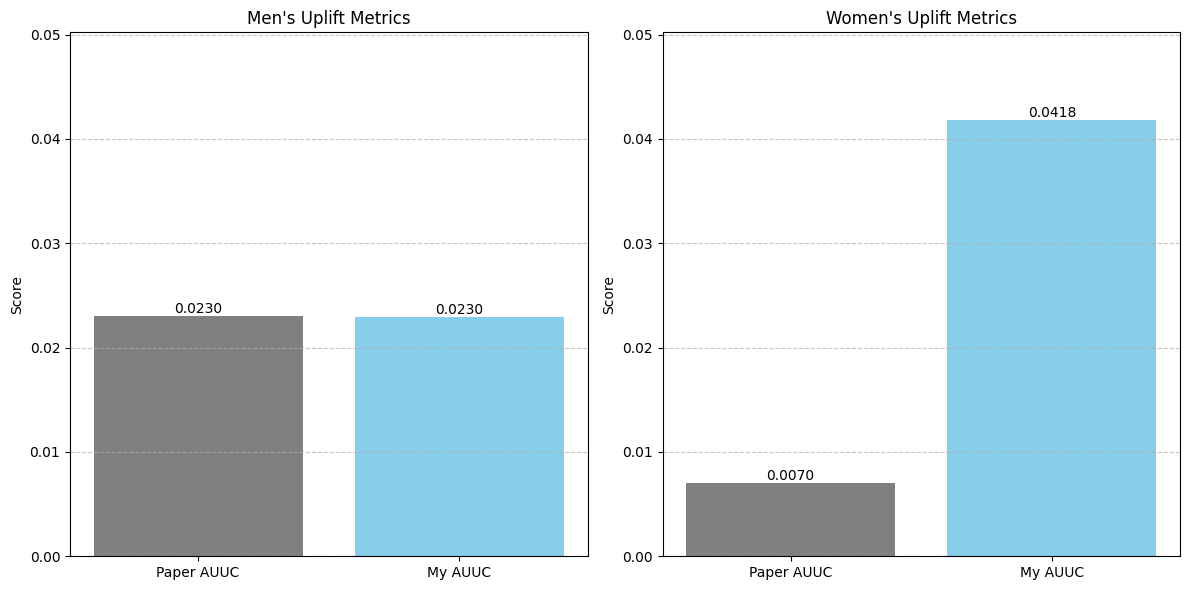

In [ ]:
paper_men, paper_women =  0.024,  0.008
best_model_men, best_model_women = 0.022969296736828997, 0.041845136573858605

# Data you provided
metrics = ['Paper AUUC', 'My AUUC']
men_values = [paper_men, best_model_men]
women_values = [paper_women, best_model_women]

# Setup figure and axes (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Define colors for distinction
colors = ['gray', 'skyblue', 'lightgreen']

# --- Plot Men ---
bars1 = ax1.bar(metrics, men_values, color=colors)
ax1.set_title("Men's Uplift Metrics")
ax1.set_ylabel("Score")
# Set unified y-limit for easier comparison
max_val = max(men_values + women_values)
ax1.set_ylim(0, max_val * 1.2) 
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

# --- Plot Women ---
bars2 = ax2.bar(metrics, women_values, color=colors)
ax2.set_title("Women's Uplift Metrics")
ax2.set_ylabel("Score")
ax2.set_ylim(0, max_val * 1.2)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

# Layout adjustment
plt.tight_layout()
plt.show()